# Greg's Job Search

In [1]:
import pandas as pd

# Load the uploaded Excel file
file_path = '/Users/Documents/Job Searching/0-GitHub/GMP JOB SEARCH - 2025.xlsx'
xls = pd.ExcelFile(file_path)

# Show sheet names to understand structure
xls.sheet_names

['Sheet1']

In [2]:
# Load the data from Sheet1
df = pd.read_excel(file_path, sheet_name="Sheet1")

# Preview first few rows and column names
df.head(), df.columns


(                          COMPANY  WORK PLACE    LOCATION Unnamed: 3  \
 0                              NaN        NaN        City      State   
 1  Federal Bureau of Investigation    On-site         NaN        USA   
 2                           Airbnb     Remote         NaN        USA   
 3                        Anthropic    On-site    New York         NY   
 4                        Brilliant     Remote  Boca Raton         FL   
 
   POSITION TYPE                 "OTHER" POSITION TYPE/ DETAILS DATE APLIED  \
 0           NaN                                            NaN         NaT   
 1         Other  Special Agent in Advanced Data & Intelligence  2025-08-03   
 2         Other                      Product Marketing Manager  2025-08-09   
 3  Data Analyst                                            NaN  2025-08-19   
 4  Data Analyst                            Junior Data Analyst  2025-08-13   
 
        SALARY RANGE Unnamed: 8  Unnamed: 9 APPLIED?  \
 0  Annual or Hourly        

In [6]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File + sheet
FILE_PATH = '/Users/Documents/Job Searching/0-GitHub/GMP JOB SEARCH - 2025.xlsx'
SHEET = 'Sheet1'

# Load
df = pd.read_excel(FILE_PATH, sheet_name=SHEET)

# Standardize column names (strip, collapse spaces)
df.columns = [c.strip().replace('\n',' ').replace('  ', ' ') for c in df.columns]

# Fix common header typos
df = df.rename(columns={
    'COMPANY ': 'COMPANY',
    'DATE APLIED': 'DATE_APPLIED',
    'Unnamed: 3': 'STATE',
    '"OTHER" POSITION TYPE/ DETAILS': 'OTHER_POSITION_DETAILS',
    'APPLIED?': 'APPLIED',
    'INTERVIEW SCHEDULED': 'INTERVIEW_SCHEDULED',
    'DATE OF INTERVIEW': 'DATE_INTERVIEW',
})

# Parse dates
for col in ['DATE_APPLIED', 'DATE_INTERVIEW']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Normalize selected text fields
text_cols = ['WORK PLACE','LOCATION','STATE','POSITION TYPE','STATUS',
             'INTERVIEW_SCHEDULED','OFFER','ACCEPTANCE OF OFFER','APPLIED']
for c in text_cols:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip().str.title().replace({'Nan': np.nan})

# City, State combo (optional)
df['CITY_STATE'] = np.where(
    df.get('LOCATION').notna() & df.get('STATE').notna(),
    df['LOCATION'] + ', ' + df['STATE'],
    df['LOCATION'].fillna('')
)

# Derive a single pipeline stage from several fields
def derive_stage(row):
    accepted = str(row.get('ACCEPTANCE OF OFFER', '')).strip().lower() == 'yes'
    offer = str(row.get('OFFER', '')).strip().lower() == 'yes'
    interview = (str(row.get('INTERVIEW_SCHEDULED', '')).strip().lower() == 'yes')
    status = str(row.get('STATUS', '')).strip().lower()

    if accepted:
        return 'Accepted Offer'
    if offer:
        return 'Offer'
    if interview or ('schedule interview' in status):
        return 'Interview'
    if any(k in status for k in ['closed', 'denied', 'rejected']):
        return 'Rejected/Closed'
    if ('awaiting response' in status) or (status == '') or (status == 'nan'):
        return 'Awaiting Response'
    return 'Other'

df['STAGE'] = df.apply(derive_stage, axis=1)

# Flags for funnel
df['applied_flag']   = df['DATE_APPLIED'].notna()
df['response_flag']  = df['STATUS'].fillna('').str.contains('Response', case=False)
df['interview_flag'] = (df['INTERVIEW_SCHEDULED'].fillna('').str.lower() == 'yes') | \
                       df['STATUS'].fillna('').str.contains('schedule interview', case=False)
df['offer_flag']     = (df['OFFER'].fillna('').str.lower() == 'yes')
df['accept_flag']    = (df['ACCEPTANCE OF OFFER'].fillna('').str.lower() == 'yes')


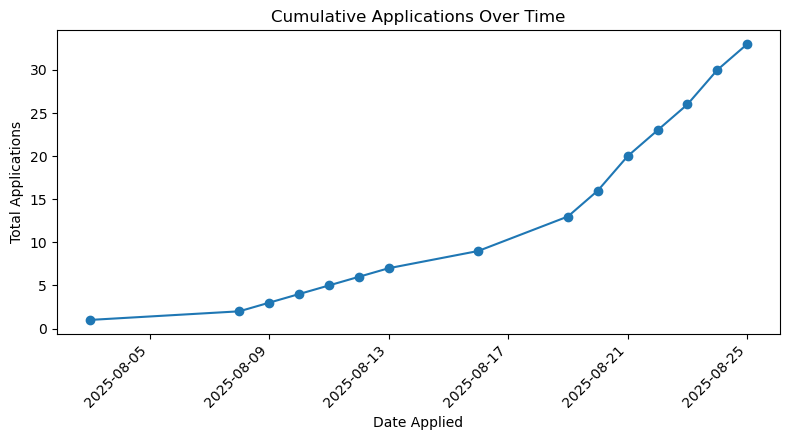

In [7]:
apps_time = df[df['DATE_APPLIED'].notna()].copy()

if apps_time.empty:
    print("No DATE_APPLIED values found.")
else:
    daily = apps_time.groupby(apps_time['DATE_APPLIED'].dt.date).size().sort_index()
    cum = daily.cumsum()

    plt.figure(figsize=(8, 4.5))
    plt.plot(cum.index, cum.values, marker='o')
    plt.title('Cumulative Applications Over Time')
    plt.xlabel('Date Applied')
    plt.ylabel('Total Applications')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


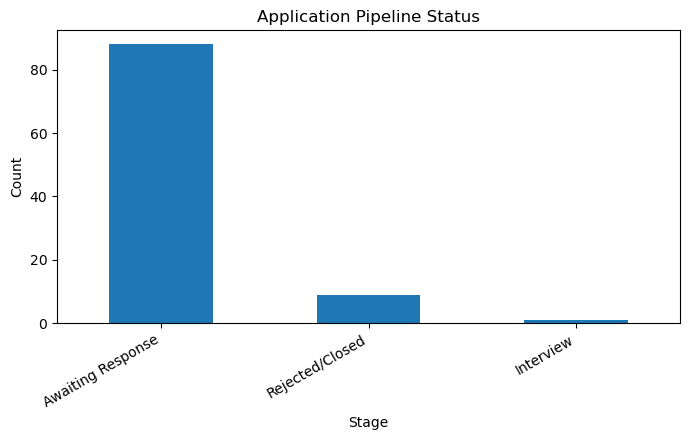

In [8]:
stage_counts = df['STAGE'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(7, 4.5))
stage_counts.plot(kind='bar')
plt.title('Application Pipeline Status')
plt.xlabel('Stage')
plt.ylabel('Count')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


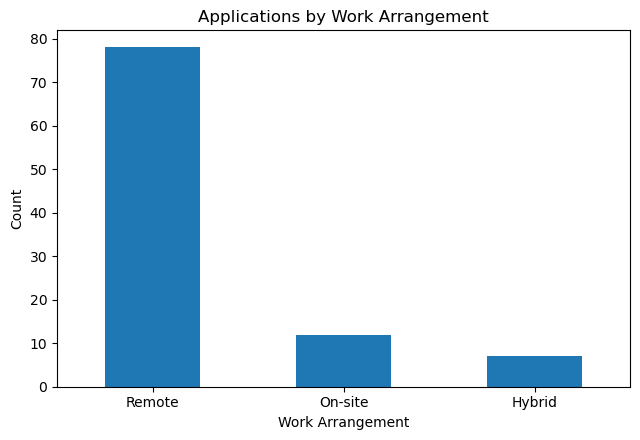

In [9]:
if 'WORK PLACE' not in df.columns:
    print("Column 'WORK PLACE' not found.")
else:
    # Normalize some common variants
    wp = df['WORK PLACE'].dropna().replace({
        'On-Site': 'On-site',
        'Remote ': 'Remote',
        'Hybrid ': 'Hybrid'
    })
    counts = wp.value_counts()

    if counts.empty:
        print("No work arrangement data to plot.")
    else:
        plt.figure(figsize=(6.5, 4.5))
        counts.plot(kind='bar')
        plt.title('Applications by Work Arrangement')
        plt.xlabel('Work Arrangement')
        plt.ylabel('Count')
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()


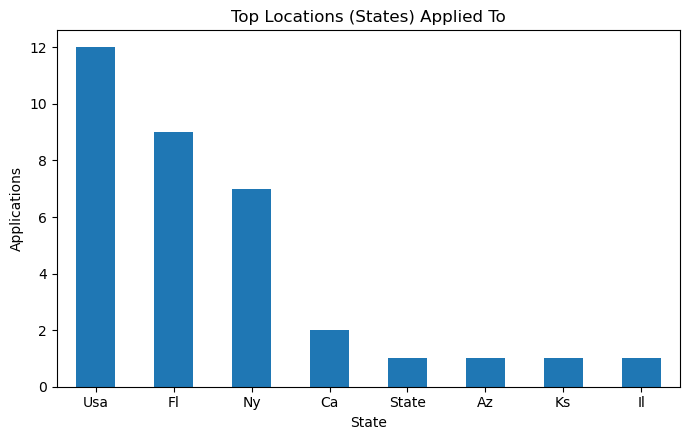

In [10]:
 if 'STATE' not in df.columns:
    print("Column 'STATE' not found.")
else:
    top_states = df['STATE'].dropna().value_counts().head(10)

    if top_states.empty:
        print("No state data to plot.")
    else:
        plt.figure(figsize=(7, 4.5))
        top_states.plot(kind='bar')
        plt.title('Top Locations (States) Applied To')
        plt.xlabel('State')
        plt.ylabel('Applications')
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()


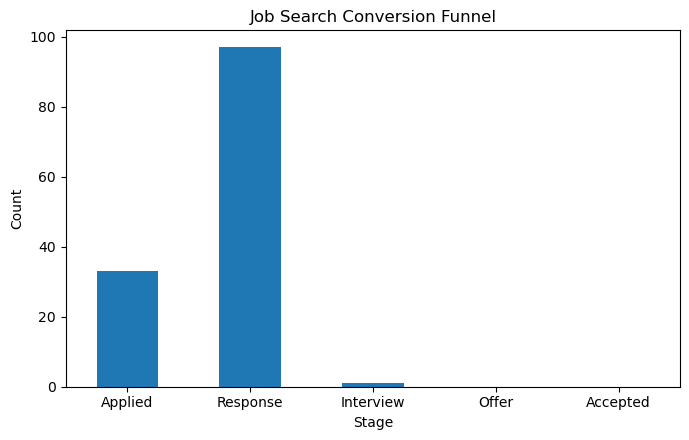

In [11]:
funnel = pd.Series({
    'Applied':  int(df['applied_flag'].sum()),
    'Response': int(df['response_flag'].sum()),
    'Interview':int(df['interview_flag'].sum()),
    'Offer':    int(df['offer_flag'].sum()),
    'Accepted': int(df['accept_flag'].sum())
})

plt.figure(figsize=(7, 4.5))
funnel.plot(kind='bar')
plt.title('Job Search Conversion Funnel')
plt.xlabel('Stage')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [12]:
clean_cols = ['COMPANY','POSITION TYPE','OTHER_POSITION_DETAILS','WORK PLACE',
              'LOCATION','STATE','CITY_STATE','DATE_APPLIED','STATUS',
              'INTERVIEW_SCHEDULED','DATE_INTERVIEW','OFFER','SALARY',
              'SALARY RANGE','ACCEPTANCE OF OFFER','STAGE']

keep = [c for c in clean_cols if c in df.columns]
df[keep].to_csv('job_applications_clean.csv', index=False)
print("Saved job_applications_clean.csv")


Saved job_applications_clean.csv
